In [1]:
#don't change this cell
import pandas as pd
import torch
from torch import Tensor, nn,optim
from torch.utils.data.dataset import Dataset
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pylab as plt

In [2]:
#don't change this cell
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
#do not change this cell
class CSVDataset(Dataset):
    def __init__(self, path: str):
        self.data = pd.get_dummies(pd.read_csv(path), columns=['Species']).astype(float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        row = self.data.iloc[idx]
        features = torch.tensor(row[:-3].values, dtype=torch.float32)
        label = torch.tensor([row.iloc[-3],row.iloc[-2],row.iloc[-1]], dtype=torch.float32)
        return features, label
    
    @property
    def classes(parameter_list):
        return ['Iris-setosa','Iris-versicolor','Iris-virginica']

In [4]:
import os

base_path = os.getcwd()

#TODO change pathes
path_train = os.path.join(base_path, "Iris-Train.csv")
path_test = os.path.join(base_path, "Iris-Test.csv")

dataset_train = CSVDataset(path_train)
dataset_test = CSVDataset(path_test)

In [5]:
from torch.utils.data import DataLoader

#TODO set parameters
loader_train = DataLoader(
    dataset=dataset_train,
    batch_size= 8,
    shuffle = True
)
loader_test = DataLoader(
    dataset=dataset_test,
    batch_size= 16,
    shuffle = True
)

In [6]:
#don't change this cell
print(f"batch   size\t= {loader_train.batch_size}")
print(f"train   size\t= {len(dataset_train):,}")
print(f"test    size\t= {len(dataset_test):,}")
print(f"Class   names\t= {dataset_train.classes}")
print(f"input   shape\t= {dataset_train[0][0].shape}")
print(f"output  shape\t= {dataset_train[0][1].shape}")
print(f"example input\t= {dataset_train[0][0]}")
print(f"example output\t= {dataset_train[0][1]}")
print(f"example label\t= {dataset_train.classes[dataset_train[0][1].argmax()]}")

batch   size	= 8
train   size	= 105
test    size	= 60
Class   names	= ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
input   shape	= torch.Size([4])
output  shape	= torch.Size([3])
example input	= tensor([5.1000, 3.5000, 1.4000, 0.2000])
example output	= tensor([1., 0., 0.])
example label	= Iris-setosa


In [7]:
# TODO: Define your model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # Example architecture for classification
        self.layer1 = nn.Linear(in_features=4, out_features=16)  # Input size 4, hidden size 16
        self.relu = nn.ReLU()  # Non-linearity
        self.layer2 = nn.Linear(in_features=16, out_features=3)  # Output size 3 (for 3 classes)

    def forward(self, x: Tensor) -> Tensor:
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

In [16]:
#don't change this cell
model = MyModel().to(device)
_ = summary(model,[5])

TypeError: Value after * must be an iterable, not int

In [17]:
#don't change this cell
def one_epoch_learning(
    model: nn.Module,
    criterion: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
) -> int:
    model.train()
    accs = 0
    for data, label in loader:
        data: Tensor = data.to(device)
        label: Tensor = label.to(device)

        optimizer.zero_grad()
        res: Tensor = model(data)
        loss: Tensor = criterion(res, label)
        loss.backward()
        optimizer.step()
        accs += (res.argmax(dim=1) == label.argmax(dim=1)).sum().item()
    return accs

In [18]:
#don't change this cell
def calculate_accuracy(
    model: nn.Module, loader: DataLoader, criterion: nn.Module
) -> int:
    model.eval()
    accs = 0
    for data, label in loader:
        data: Tensor = data.to(device)
        label: Tensor = label.to(device)

        res: Tensor = model(data)      
          
        accs += (res.argmax(dim=1) == label.argmax(dim=1)).sum().item()
    return accs

In [19]:
#don't change this cell
def train(
    model: nn.Module,
    criterion: nn.Module,
    loader_train: DataLoader,
    loader_test: DataLoader,
    optimizer: optim.Optimizer,
    epoch: int,
):
    results_train = []
    results_test = []
    for i in tqdm(range(epoch)):
        res_train = one_epoch_learning(model, criterion, loader_train, optimizer)
        results_train.append(res_train / len(loader_train.dataset))
        res_test = calculate_accuracy(model, loader_test, criterion)
        results_test.append(res_test / len(loader_test.dataset))
    return results_train, results_test

In [23]:
#TODO set EPOCH and optimizer and loss function
EPOCH = 40
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()
train_accs, test_accs = train(model, loss, loader_train, loader_test, optimizer, EPOCH)

100%|██████████| 40/40 [00:01<00:00, 33.03it/s]


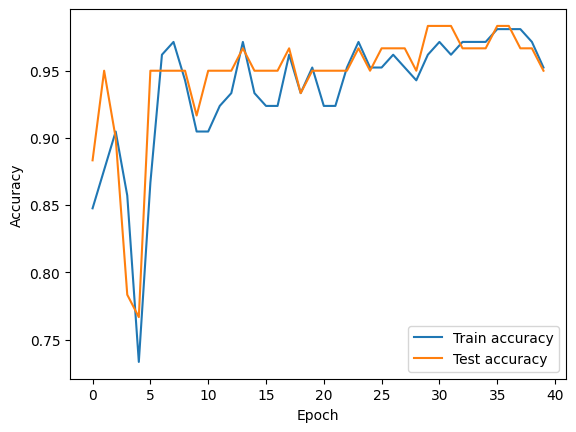

In [24]:
#don't change this cell
plt.plot(train_accs, label="Train accuracy")
plt.plot(test_accs, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [25]:
#don't change this cell
print(f"final train acc = {train_accs[-1]:.5f}")
print(f"final test acc = {test_accs[-1]:.5f}")
print(f"max train acc = {max(train_accs):.5f}")
print(f"max test acc = {max(test_accs):.5f}")
print(f"min train acc = {min(train_accs):.5f}")
print(f"min test acc = {min(test_accs):.5f}")

final train acc = 0.95238
final test acc = 0.95000
max train acc = 0.98095
max test acc = 0.98333
min train acc = 0.73333
min test acc = 0.76667
